---
# [1] load DEM

In [2]:
from pathlib import Path

import xarray as xr
import rioxarray
# import rasterio

import numpy as np

import matplotlib.pyplot as plt

In [3]:
"""
REFERENCES:
------------
    Mars MGS MOLA DEM 463m v2:
        > https://astrogeology.usgs.gov/search/map/Mars/GlobalSurveyor/MOLA/Mars_MGS_MOLA_DEM_mosaic_global_463m
    Mars MGS MOLA - MEX HRSC Blended DEM Global 200m v2:
        > https://astrogeology.usgs.gov/search/map/Mars/Topography/HRSC_MOLA_Blend/Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2
"""


'''read DEM (digital elevation model) to xarray'''
fpath_dem = r'C:\Users\Eris\Downloads\marscraters\Mars_MGS_MOLA_DEM_mosaic_global_463m.tif'
# fpath_dem = r'C:\Users\Eris\AppData\Local\redplanet\redplanet\Cache\Maps\Mars_HRSC_MOLA_BlendDEM_Global_200mp_v2.tif'

fpath_dem = Path(fpath_dem)
# dat_dem = rioxarray.open_rasterio(fpath_dem, chunks={'x': 1000, 'y': 1000}).sel(band=1).drop_vars(['band', 'spatial_ref'])
# dat_dem = rioxarray.open_rasterio(fpath_dem, chunks={'x': chunk_width, 'y': chunk_height}).sel(band=1).drop_vars(['band', 'spatial_ref'])
dat_dem = rioxarray.open_rasterio(fpath_dem, chunks={'x': 'auto', 'y': 'auto'}).sel(band=1).drop_vars(['band', 'spatial_ref'])

## convert:     elevation wrt sea level [m] --> topography wrt center [km]
# dat_dem = (dat_dem + R) * 1e-3    # '''NOTE: THIS INCREASES ARRAY SIZE FROM 2GB TO 8GB!!!! DON'T DO THIS NOW!!!'''


'''transform coordinates to lon/lat     NOTE: (USE ONLY FOR 463m MAP, NOT 200m!)'''

R = 3396190.0   # mars radius per IAU 2000 definition
standard_parallel = 0 
scale = np.cos(np.radians(standard_parallel))

dat_dem['x'] = ((dat_dem.x / (R * scale)) * (180 / np.pi)).data
dat_dem['y'] = ((dat_dem.y / R) * (180 / np.pi)).data






## rename
dat_dem = dat_dem.rename({'x': 'lon', 'y': 'lat'})
dat_dem = dat_dem.sortby('lat')

dat_dem

<xarray.DataArray (lat: 23040, lon: 46080)> Size: 2GB
dask.array<getitem, shape=(23040, 46080), dtype=int16, chunksize=(8192, 8192), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 369kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 184kB -90.0 -89.99 -89.98 -89.97 ... 89.98 89.99 90.0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

In [81]:
# '''OPTIONAL'''

# downsample_factor = 5
# # downsample_factor = 10
# dat_dem = dat_dem.coarsen(lon=downsample_factor, lat=downsample_factor, boundary='trim').mean()

# dat_dem

---
# [2.x] TEMP for geo527 lab3

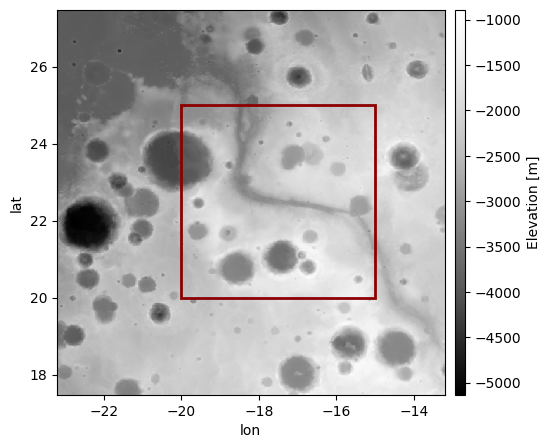

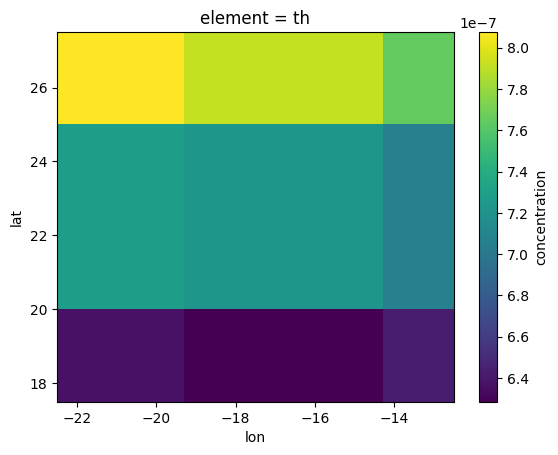

In [101]:
# lon_bounds = (-18.35, -18.05)
# lat_bounds = (22.35, 22.65)

# lon_bounds = (-19.5, -)
# lat_bounds = (22.35, 22.65)

region_name = 'Mawrth Vallis'
center = [-18.207332,22.480411]     # copy-paste from act quickmap
radius = 5

lon_bounds = (center[0]-radius, center[0]+radius)
lat_bounds = (center[1]-radius, center[1]+radius)



grid_spacing = 0.01
# grid_spacing = 0.1
# grid_spacing = 0


if grid_spacing == 0:
    dat_region = dat_dem.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    lons = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing )
    lats = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing )

    dat_region = dat_dem.sel(
        lon = lons, 
        lat = lats, 
        method = 'nearest',
    )




fig = plt.figure(figsize=(5,5))
ax = plt.axes()

im_dat = dat_region.plot.imshow(ax=ax, cmap='Greys_r', add_colorbar=False)


rect = plt.Rectangle(
    (-17.5 - 2.5, 22.5 - 2.5), 
    5, 5,
    edgecolor = 'darkred', 
    facecolor = 'none', 
    linewidth = 2, 
    alpha     = 1, 
)
ax.add_patch(rect)

cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im_dat, cax=cax)
cbar.set_label(f'Elevation [m]', y=0.5)



# dat_region_arr = dat_region.values




fig = plt.figure()

from redplanet import GRS

dat_grs = GRS.get_rawdata('xarray')

dat_grs_region = dat_grs.sel(
    lon = lons, 
    lat = lats, 
    method = 'nearest',
)

dat_grs_region.sel(element='th').concentration.plot.imshow()

# dat_grs_region_arr = dat_grs_region.values

In [93]:
dat_grs.lon.values

array([-177.5, -172.5, -167.5, -162.5, -157.5, -152.5, -147.5, -142.5,
       -137.5, -132.5, -127.5, -122.5, -117.5, -112.5, -107.5, -102.5,
        -97.5,  -92.5,  -87.5,  -82.5,  -77.5,  -72.5,  -67.5,  -62.5,
        -57.5,  -52.5,  -47.5,  -42.5,  -37.5,  -32.5,  -27.5,  -22.5,
        -17.5,  -12.5,   -7.5,   -2.5,    2.5,    7.5,   12.5,   17.5,
         22.5,   27.5,   32.5,   37.5,   42.5,   47.5,   52.5,   57.5,
         62.5,   67.5,   72.5,   77.5,   82.5,   87.5,   92.5,   97.5,
        102.5,  107.5,  112.5,  117.5,  122.5,  127.5,  132.5,  137.5,
        142.5,  147.5,  152.5,  157.5,  162.5,  167.5,  172.5,  177.5])

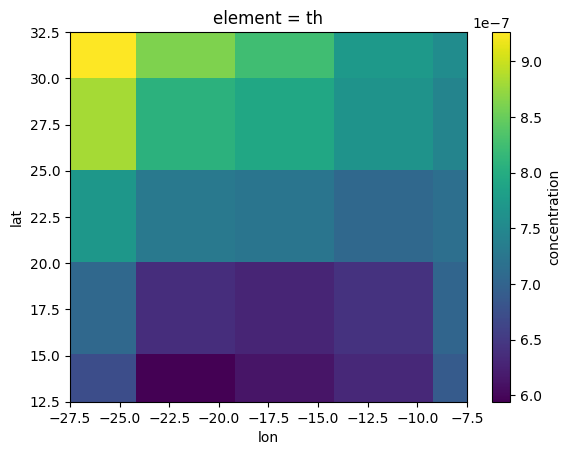

In [49]:
from redplanet import GRS

dat_grs = GRS.get_rawdata('xarray')

dat_grs_region = dat_grs.sel(
    lon = lons, 
    lat = lats, 
    method = 'nearest',
)

dat_grs_region.sel(element='th').concentration.plot.imshow()

In [45]:
center

[-18.207332, 22.480411]

In [75]:
summary = {
    'element'           : ['al', 'ca', 'cl', 'fe', 'h2o', 'k', 's', 'si', 'th'], 
    'concentration'     : [], 
    'sigma'             : [], 
    't'                 : [],
    'concentration_norm': [], 
    'sigma_norm'        : [], 
    't_norm'            : [], 
}

# elements = ['al', 'ca', 'cl', 'fe', 'h2o', 'k', 's', 'si', 'th', 'volatiles']

for element in summary['element']:

    conc  = dat_grs.sel(element=element).sel(lon=center[0], lat=center[1], method='nearest').concentration.item()
    sigma = dat_grs.sel(element=element).sel(lon=center[0], lat=center[1], method='nearest').sigma        .item()

    summary['concentration'].append(conc)
    summary['sigma']        .append(sigma)



    conc_all  = np.nanmean(dat_grs.sel(element=element).concentration.values)
    sigma_all = np.nanstd (dat_grs.sel(element=element).concentration.values)

    t = (conc - conc_all) / np.sqrt(sigma**2 + sigma_all**2)

    summary['t'].append(t)


    if element in ['cl', 'h2o', 's']:
        summary['concentration_norm'].append(None)
        summary['sigma_norm']        .append(None)
        summary['t_norm']            .append(None)
        continue

    
    conc_vols  = dat_grs.sel(element='volatiles').sel(lon=center[0], lat=center[1], method='nearest').concentration.item()
    sigma_vols = dat_grs.sel(element='volatiles').sel(lon=center[0], lat=center[1], method='nearest').sigma        .item()

    conc_norm  = conc  / (1-conc_vols )
    sigma_norm = sigma / (1-sigma_vols)

    summary['concentration_norm'].append(conc_norm)
    summary['sigma_norm']        .append(sigma_norm)



    conc_norm_all  = np.nanmean(dat_grs.sel(element=element).concentration.values / (1-dat_grs.sel(element='volatiles').concentration.values))
    sigma_norm_all = np.nanstd (dat_grs.sel(element=element).concentration.values / (1-dat_grs.sel(element='volatiles').concentration.values))

    t_norm = (conc_norm - conc_norm_all) / np.sqrt(sigma_norm**2 + sigma_norm_all**2)

    summary['t_norm'].append(t_norm)


In [77]:
import pandas as pd

In [79]:
pd.DataFrame(summary).to_csv('geo527lab3.csv')

---
---
# [2] Global Map

---
## [2.1] plotly 3d

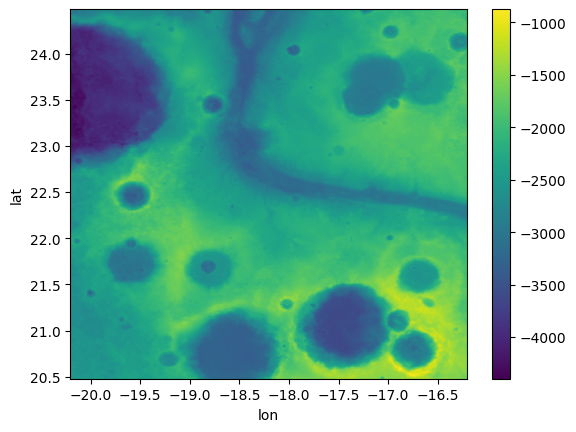

In [33]:
# lon_bounds = (-18.35, -18.05)
# lat_bounds = (22.35, 22.65)

# lon_bounds = (-19.5, -)
# lat_bounds = (22.35, 22.65)

region_name = 'Mawrth Vallis'
center = [-18.207332,22.480411]     # copy-paste from act quickmap
radius = 2

lon_bounds = (center[0]-radius, center[0]+radius)
lat_bounds = (center[1]-radius, center[1]+radius)



# grid_spacing = 0.1
grid_spacing = 0


if grid_spacing == 0:
    dat_region = dat_dem.sel(
        lon = slice( lon_bounds[0], lon_bounds[1] ), 
        lat = slice( lat_bounds[0], lat_bounds[1] ),
    )
else:
    dat_region = dat_dem.sel(
        lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
        lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
        method = 'nearest',
    )

dat_region.plot.imshow(cmap='viridis')

In [34]:
vertical_scale_factor = 0.1

coarsening_factor = 2
dat_region = dat_region.coarsen(lon=coarsening_factor, lat=coarsening_factor, boundary='trim').mean()


#############################################################


data = dat_region.values
lons = dat_region.lon.values
lats = dat_region.lat.values

import plotly.graph_objects as go
from plotly.offline import plot

## create fig
fig = go.Figure(data=[go.Surface(
    z=data, 
    x=lons, 
    y=lats, 
    # colorscale='RdBu',
    colorscale='Viridis',
)])


## format fig
fig.update_layout(
    title    = f'{region_name} MOLA DEM (200m res)',
    autosize = True,
    width    = 1000,
    height   = 1000,
    margin   = dict(l=65, r=50, b=65, t=90),
    scene    = dict(
        aspectmode  = 'manual',
        aspectratio = dict(x=1, y=1, z=vertical_scale_factor),  # Reducing z-axis scale
        xaxis_title = 'Longitude',
        yaxis_title = 'Latitude',
        zaxis_title = 'Elevation [m]'
    )
)

fig['data'][0].update(colorbar=dict(title='Elevation [m]'))



## OPTIONAL: add point at desired coordinate
z_value = data[np.argmin(np.abs(lats - center[1]))][np.argmin(np.abs(lons - center[0]))]
z_value -= -100

fig.add_trace(go.Scatter3d(
    x=[center[0]],
    y=[center[1]],
    z=[z_value],
    mode='markers',
    marker=dict(
        size=5,  # Size of the marker
        color='red',  # Color of the marker
    ),
))




# Show plot in a new browser window
plot(fig, filename=f'SurfacePlot_DEM_{region_name.replace(" ", "-")}.html')

'SurfacePlot_DEM_Mawrth-Vallis.html'

---
## [2.2] Hillshade

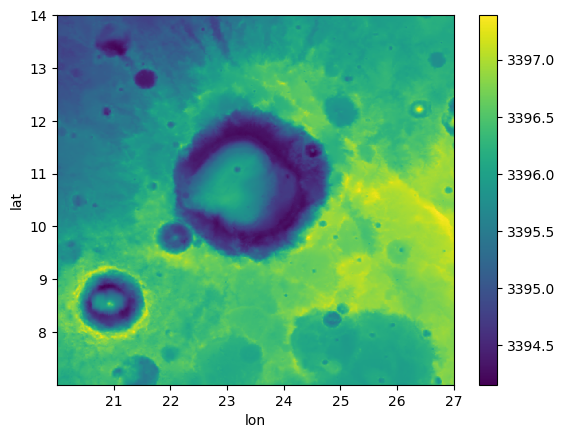

In [3]:
# lon_bounds = (20, 27)
# lat_bounds = (7, 14)
# # grid_spacing = 0.1
# grid_spacing = 0

# if grid_spacing == 0:
#     crater = dat_dem.sel(
#         lon = slice( lon_bounds[0], lon_bounds[1] ), 
#         lat = slice( lat_bounds[0], lat_bounds[1] ),
#     )
# else:
#     crater = dat_dem.sel(
#         lon = np.arange( lon_bounds[0], lon_bounds[1], grid_spacing ), 
#         lat = np.arange( lat_bounds[0], lat_bounds[1], grid_spacing ), 
#         method = 'nearest',
#     )


# crater.plot.imshow(cmap='viridis')

In [33]:
# def calculate_hillshade(arr, azimuth=225, altitude=60):
#     """
#     Create hillshade from a numpy array containing elevation data.
    
#     Parameters
#     ----------
#     arr : numpy array of shape (rows, columns)
#         Numpy array containing elevation values to be used to created hillshade.
#     azimuth : float (default=30)
#         The desired azimuth for the hillshade.
#     altitude : float (default=30)
#         The desired sun angle altitude for the hillshade.
    
#     Returns
#     -------
#     numpy array
#         A numpy array containing hillshade values.
    
#     Example
#     -------
#     .. plot::
#         >>> import matplotlib.pyplot as plt
#         >>> import rasterio as rio
#         >>> import earthpy.spatial as es
#         >>> from earthpy.io import path_to_example
#         >>> with rio.open(path_to_example('rmnp-dem.tif')) as src:
#         ...     dem = src.read()
#         >>> print(dem.shape)
#         (1, 187, 152)
#         >>> squeezed_dem = dem.squeeze() # remove first dimension
#         >>> print(squeezed_dem.shape)
#         (187, 152)
#         >>> shade = es.hillshade(squeezed_dem)
#         >>> plt.imshow(shade, cmap="Greys")
#         <matplotlib.image.AxesImage object at 0x...>
#     """
#     try:
#         x, y = np.gradient(arr)
#     except:
#         raise ValueError("Input array should be two-dimensional")

#     if azimuth <= 360.0:
#         azimuth = 360.0 - azimuth
#         azimuthrad = azimuth * np.pi / 180.0
#     else:
#         raise ValueError(
#             "Azimuth value should be less than or equal to 360 degrees"
#         )

#     if altitude <= 90.0:
#         altituderad = altitude * np.pi / 180.0
#     else:
#         raise ValueError(
#             "Altitude value should be less than or equal to 90 degrees"
#         )

#     slope = np.pi / 2.0 - np.arctan(np.sqrt(x * x + y * y))
#     aspect = np.arctan2(-x, y)

#     shaded = np.sin(altituderad) * np.sin(slope) + np.cos(
#         altituderad
#     ) * np.cos(slope) * np.cos((azimuthrad - np.pi / 2.0) - aspect)

#     return 255 * (shaded + 1) / 2

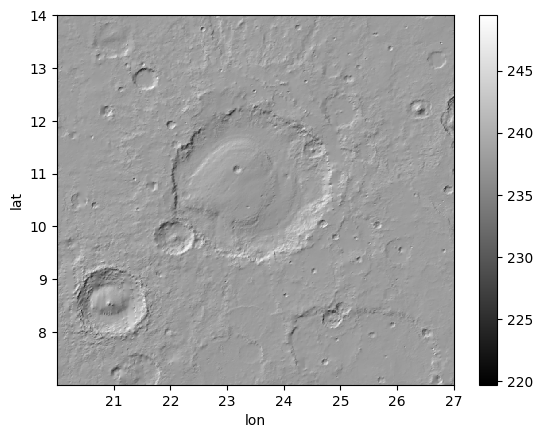

In [34]:
# hillshade = calculate_hillshade(crater)

# # plt.imshow(hillshade)

# hillshade = xr.DataArray(hillshade, coords=crater.coords, dims=crater.dims)
# hillshade.plot(cmap='grey')

---
---
# [3] Compare

In [25]:
from redplanet import Crust
Crust.load_topo()
dat_cr = Crust.get_rawdata('xarray').topo

---
## [3.1] Tikhanravov

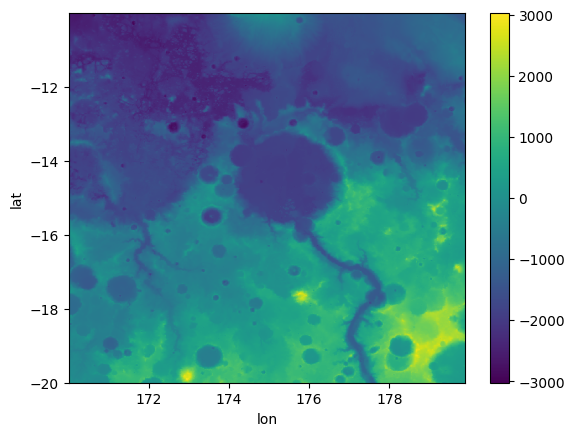

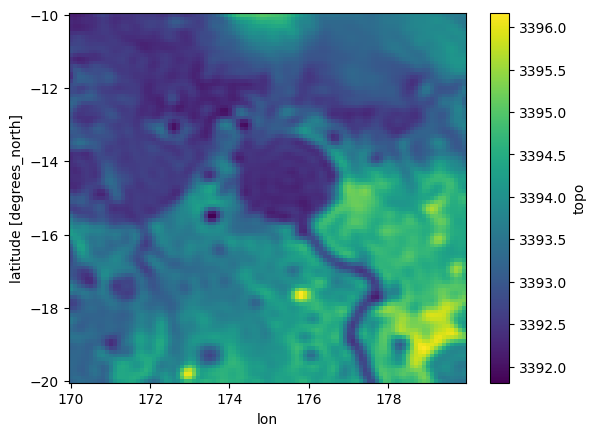

In [6]:
plt.figure()
crater = dat_dem.sel(lon=slice(170,179.9), lat=slice(-20,-10))
crater.plot.imshow(cmap='viridis')

plt.figure()
crater = dat_cr.sel(lon=slice(170,179.9), lat=slice(-20,-10))
crater.plot.imshow()

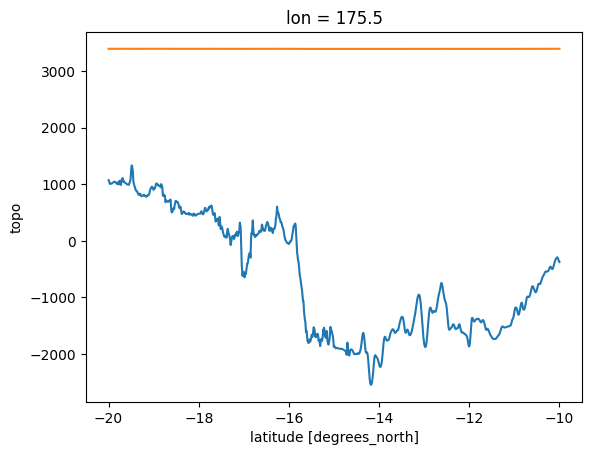

In [22]:
plt.figure()
crater = dat_dem.sel(lon=175.5, method='nearest').sel(lat=slice(-20,-10))
crater.plot()

# plt.figure()
crater = dat_cr.sel(lon=175.5, method='nearest').sel(lat=slice(-20,-10))
crater.plot()

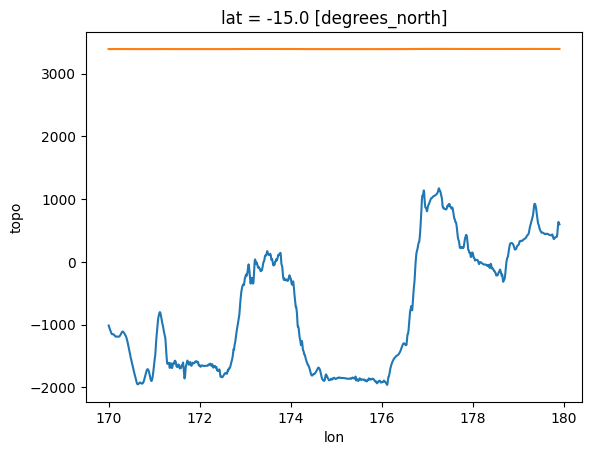

In [23]:
plt.figure()
crater = dat_dem.sel(lat=-15, method='nearest').sel(lon=slice(170,179.9))
crater.plot()

# plt.figure()
crater = dat_cr.sel(lat=-15, method='nearest').sel(lon=slice(170,179.9))
crater.plot()

In [36]:
crater = dat_dem.sel(lon=slice(170,179.9), lat=slice(-20,-10))

vertical_scale_factor = 0.1

coarsening_factor = 2
crater = crater.coarsen(lon=coarsening_factor, lat=coarsening_factor, boundary='trim').mean()


#############################################################



data = crater.values
lons = crater.lon.values
lats = crater.lat.values
import plotly.graph_objects as go
from plotly.offline import plot

# Create a figure
fig = go.Figure(data=[go.Surface(
    z=data, 
    x=lons, 
    y=lats, 
    colorscale='RdBu'
)])


# Update layout
fig.update_layout(
    title='3D Surface plot',
    autosize = False,
    width    = 1000,
    height   = 1000,
    margin   = dict(l=65, r=50, b=65, t=90),
    scene    = dict(
        aspectmode  = 'manual',
        aspectratio = dict(x=1, y=1, z=vertical_scale_factor),  # Reducing z-axis scale
        xaxis_title = 'Longitude',
        yaxis_title = 'Latitude',
        zaxis_title = 'Elevation [m]'
    )
)

fig['data'][0].update(colorbar=dict(title='Elevation [m]'))


# Show plot in a new browser window
plot(fig, filename='temp-plot_tikhon_hires.html')

'temp-plot_tikhon_hires.html'

---
## [3.2] Henry

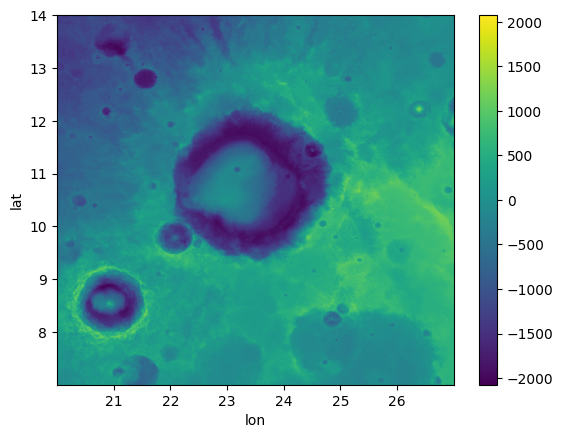

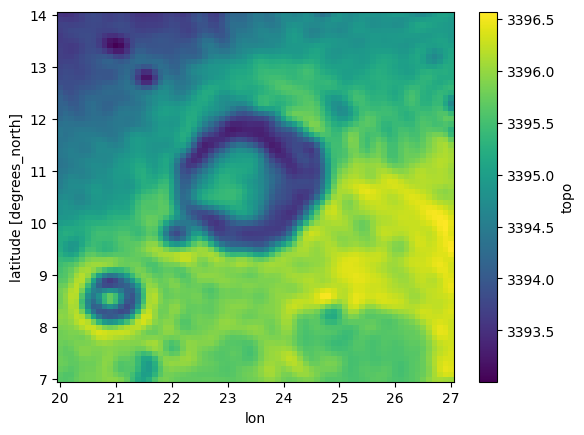

In [24]:
plt.figure()
crater = dat_dem.sel(lon=slice(20,27), lat=slice(7,14))
crater.plot.imshow(cmap='viridis')

plt.figure()
crater = dat_cr.sel(lon=slice(20,27), lat=slice(7,14))
crater.plot.imshow()

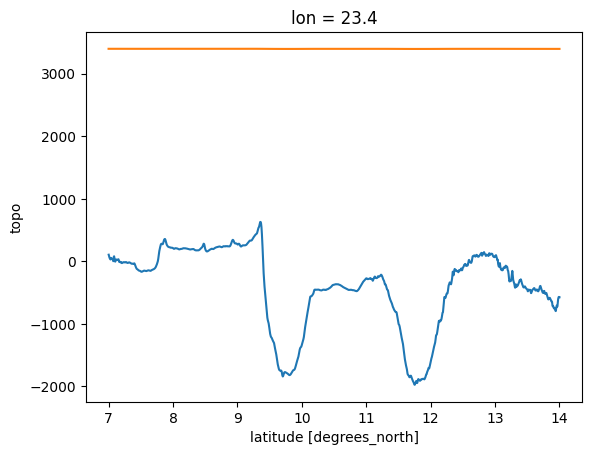

In [25]:
plt.figure()
crater = dat_dem.sel(lon=23.4, method='nearest').sel(lat=slice(7,14))
crater.plot()

# plt.figure()
crater = dat_cr.sel(lon=23.4, method='nearest').sel(lat=slice(7,14))
crater.plot()

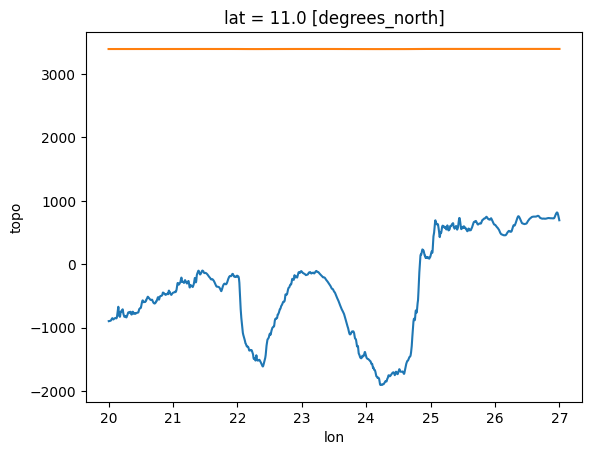

In [26]:
plt.figure()
crater = dat_dem.sel(lat=11, method='nearest').sel(lon=slice(20,27))
crater.plot()

# plt.figure()
crater = dat_cr.sel(lat=11, method='nearest').sel(lon=slice(20,27))
crater.plot()

In [1]:
crater = dat_dem.sel(lon=slice(20,27), lat=slice(7,14))

vertical_scale_factor = 0.1

coarsening_factor = 2
crater = crater.coarsen(lon=coarsening_factor, lat=coarsening_factor, boundary='trim').mean()


#############################################################



data = crater.values
lons = crater.lon.values
lats = crater.lat.values
import plotly.graph_objects as go
from plotly.offline import plot

# Create a figure
fig = go.Figure(data=[go.Surface(
    z=data, 
    x=lons, 
    y=lats, 
    colorscale='RdBu'
)])


# Update layout
fig.update_layout(
    title='3D Surface plot',
    autosize = False,
    width    = 1000,
    height   = 1000,
    margin   = dict(l=65, r=50, b=65, t=90),
    scene    = dict(
        aspectmode  = 'manual',
        aspectratio = dict(x=1, y=1, z=vertical_scale_factor),  # Reducing z-axis scale
        xaxis_title = 'Longitude',
        yaxis_title = 'Latitude',
        zaxis_title = 'Elevation [m]'
    )
)

fig['data'][0].update(colorbar=dict(title='Elevation [m]'))


# Show plot in a new browser window
plot(fig, filename='temp-plot_hiris.html')

NameError: name 'dat_dem' is not defined

---
# [-1] Scrap

In [13]:
# dat_dem.plot.imshow(cmap='viridis', figsize=(20,10))

In [14]:
# # mars radius as per IAU 2000 definition
# R = 3396190.0

# # standard parallel at 0 degrees
# standard_parallel = 0 

# # calculating the scale factor for the projection
# scale = np.cos(np.radians(standard_parallel))

# # lon and lat transformations
# dem_lons = ((dat_dem.x / (R * scale)) * (180 / np.pi)).data
# dem_lats = ((dat_dem.y / R) * (180 / np.pi)).data



# # dat_dem = xr.DataArray(data=dat_dem.values[::-1], coords={'lat': dem_lats[::-1], 'lon': dem_lons})

# # dat_dem = dat_dem.sortby('lat')

# # dat_dem

In [15]:
# with rasterio.open(fpath_dem) as dem:
#     dat_dem = dem.read(1)  # Reads the first band

#     print(dat_dem.shape)

#     # # Convert geographic coordinates to raster coordinates
#     # row, col = dem.index(lon, lat)

#     # # Access the elevation at the specified coordinates
#     # elevation_at_point = elevation_data[row, col]
#     # print(f"The elevation at latitude {lat} and longitude {lon} is {elevation_at_point} meters.")


In [16]:
# dat_dem = rioxarray.open_rasterio(fpath_dem)

# # Mars radius as per IAU 2000 definition
# R = 3396190.0

# # Standard parallel at 0 degrees
# standard_parallel = 0 

# # Calculating the scale factor for the projection
# scale = np.cos(np.radians(standard_parallel))

# # Longitude and Latitude transformation
# longitude = ((dat_dem.x / (R * scale)) * (180 / np.pi)).data
# latitude = ((dat_dem.y / R) * (180 / np.pi)).data

# # Assigning the new coordinates to the dataset
# dat_dem = dat_dem.assign_coords(lon=("x", longitude), lat=("y", latitude))

# # Drop the unwanted coordinates and sort
# dat_dem = dat_dem.drop_vars(['band', 'x', 'y', 'spatial_ref'])
# dat_dem = dat_dem.sortby('lon', ascending=True)
# dat_dem = dat_dem.sortby('lat', ascending=True)


# dat_dem

In [17]:
# dat_dem = rioxarray.open_rasterio(fpath_dem)

# # Mars radius as per IAU 2000 definition
# R = 3396190.0

# # Standard parallel at 0 degrees
# standard_parallel = 0 

# # Calculating the scale factor for the projection
# scale = np.cos(np.radians(standard_parallel))

# # Longitude and Latitude transformation
# longitude = ((dat_dem.x / (R * scale)) * (180 / np.pi)).data
# latitude = ((dat_dem.y / R) * (180 / np.pi)).data

# # Create a new DataArray with 'lon' and 'lat' as coordinates
# new_data = dat_dem.data  # Extract the data from the original DataArray
# new_lon, new_lat = np.meshgrid(longitude, latitude)  # Create a meshgrid for 'lon' and 'lat'

# # Assuming dat_dem has a single band; adjust if there are multiple bands
# new_dat_dem = xr.DataArray(new_data, coords={'lat': ('y', new_lat[:, 0]), 'lon': ('x', new_lon[0, :])}, dims=['y', 'x'])

# # Now new_dat_dem has only 'lon' and 'lat' as coordinates
# # new_dat_dem


In [18]:
# lon = np.linspace(0,10)

# # not (-180 <= lon <= 180)
# # np.any(-180 <= lon <= 360)
# np.any(lon < -180) or np.any(360 < lon)

In [19]:
# lon

In [ ]:
# crater = dat_dem.sel(lon=slice(20,27), lat=slice(7,14))

# vertical_scale_factor = 0.1

# coarsening_factor = 2
# crater = crater.coarsen(lon=coarsening_factor, lat=coarsening_factor, boundary='trim').mean()




# data = crater.values
# lons = crater.lon.values
# lats = crater.lat.values



# #############################################################


# # data = crater.values

# # def coarsen_data(data, factor):
# #     """
# #     Coarsen a 2D array by taking the mean over square regions.
# #     If the data dimensions are not evenly divisible by the factor,
# #     the excess elements at the end of each dimension are excluded.

# #     :param data: 2D numpy array
# #     :param factor: int, the coarsening factor
# #     :return: 2D numpy array, coarsened
# #     """
# #     # Calculate new dimensions that are divisible by the factor
# #     new_shape_0 = data.shape[0] - data.shape[0] % factor
# #     new_shape_1 = data.shape[1] - data.shape[1] % factor

# #     # Trim the data
# #     trimmed_data = data[:new_shape_0, :new_shape_1]

# #     # Reshape and take the mean
# #     new_shape = (new_shape_0 // factor, factor, new_shape_1 // factor, factor)
# #     coarsened_data = trimmed_data.reshape(new_shape).mean(axis=(1, 3))

# #     return coarsened_data


# # data = coarsen_data(data, coarsening_factor)


# #############################################################
# import plotly.graph_objects as go
# from plotly.offline import plot

# # Create a figure
# fig = go.Figure(data=[go.Surface(
#     z=data, 
#     x=lons, 
#     y=lats, 
#     colorscale='RdBu'
# )])


# # Update layout
# fig.update_layout(
#     title='3D Surface plot',
#     autosize = False,
#     width    = 1000,
#     height   = 1000,
#     margin   = dict(l=65, r=50, b=65, t=90),
#     scene    = dict(
#         aspectmode  = 'manual',
#         aspectratio = dict(x=1, y=1, z=vertical_scale_factor),  # Reducing z-axis scale
#         xaxis_title = 'Longitude',
#         yaxis_title = 'Latitude',
#         zaxis_title = 'Elevation [m]'
#     )
# )

# fig['data'][0].update(colorbar=dict(title='Elevation [m]'))


# # Show plot in a new browser window
# plot(fig, filename='temp-plot_hiris.html')

In [93]:
'''
NOTE: 
- ignore the code below, it's unnecessary since dask has this feature: 
    > Automatic chunking expands or contracts all dimensions marked with "auto" to try to reach chunk sizes with a number of bytes equal to the config value array.chunk-size, which is set to 128MiB by default, but which you can change in your configuration.
- autochunking is probably _better_ since it easily adapts to larger/smaller TIFs if you end up using them.
'''

# '''
# NOTE: This code was (mostly) generated with ChatGPT. Here is the conversation history in a few formats:
#     - Screenshot (image):
#         > https://files.catbox.moe/zzoxxj.png
#     - Markdown (text):
#         > https://files.catbox.moe/t4j48b.md
#     - HTML (open with browser):
#         > https://files.catbox.moe/vklhdt.html
# '''


# def calculate_optimal_chunk_size(width, height, target_chunk_size_mb, element_size_bytes):
#     """
#     Calculate the optimal chunk width and height for a given array and target chunk size.

#     :param width: Width of the original array.
#     :param height: Height of the original array.
#     :param target_chunk_size_mb: Target chunk size in megabytes.
#     :param element_size_bytes: Size of each element in bytes. Use 8 for numpy float64 or 2 for int16.
#     :return: Tuple of (chunk_width, chunk_height)
#     """
#     # Convert target chunk size to bytes
#     target_chunk_size_bytes = target_chunk_size_mb * (1024 ** 2)

#     # Calculate the number of elements per chunk
#     elements_per_chunk = target_chunk_size_bytes / element_size_bytes

#     # Approximate square dimension to maintain aspect ratio
#     chunk_dimension_size = int(elements_per_chunk ** 0.5)

#     # Function to find the closest divisor
#     def closest_divisor(number, target):
#         for i in range(target, 0, -1):
#             if number % i == 0:
#                 return i
#         return 1

#     # Find closest divisors of the original dimensions
#     chunk_width = closest_divisor(width, chunk_dimension_size)
#     chunk_height = closest_divisor(height, chunk_dimension_size)

#     return chunk_width, chunk_height



# chunk_width, chunk_height = calculate_optimal_chunk_size(
#     width=46080, 
#     height=23040, 
#     target_chunk_size_mb=200, 
#     element_size_bytes=2
# )

None